In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


Задание 1.
Задача опредления вероятности дефолта (неуплаты долга) по кредитной карте

https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset

Постройте классификатор на основе полносвязной нейронной сети для определения вероятности дефолта по кредитной карте (невозврат долга).

Экземляров данных довольно мало, поэтому не нужно упорствовать с увеличением глубины и ширины сети

Обязательное кодирование категориальных признаков

Обязательная стандартизация или масштабирование признаков

Если применяете One Hot Encoding (бинарное кодирование), то обратите внимание на регуляризацию, чтобы предотвратить переобучение

Постройте классификатор на основе автоэнкодера для решения этой же задачи аналогично примеру с мошенничествам по картам

Удачи!

In [5]:
df = pd.read_csv("datasets/UCI_Credit_Card.csv")

In [6]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [7]:
df.isnull().values.any()

False

In [14]:
y = df['default.payment.next.month']
X = df.drop(['default.payment.next.month'], axis=1)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.22)

In [81]:
X_train.index = np.arange(len(X_train))
X_test.index = np.arange(len(X_test))
y_train.index = np.arange(len(X_train))
y_test.index = np.arange(len(X_test))

In [82]:
all_cat = ['SEX',
         'EDUCATION',
         'MARRIAGE',
         'PAY_0',
         'PAY_2',
         'PAY_3',
         'PAY_4',
         'PAY_5',
         'PAY_6']

In [83]:
all_numeric = [
    'AGE',
    'LIMIT_BAL',
     'BILL_AMT1',
     'BILL_AMT2',
     'BILL_AMT3',
     'BILL_AMT4',
     'BILL_AMT5',
     'BILL_AMT6',
     'PAY_AMT1',
     'PAY_AMT2',
     'PAY_AMT3',
     'PAY_AMT4',
     'PAY_AMT5',
     'PAY_AMT6',
]

In [84]:
#  счетчики со сглаживанием
def counts(column, target, constanta):
    c = constanta
    count = dict()
    for item in (np.unique(column)):
        count[item]=(((column == item) & (target == 1)).sum() + c)/((column == item).sum() + c)
    return count

In [85]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X_train, y_train)

print(skf)  

for cat_col in all_cat:
    for train_index, test_index in skf.split(X_train, y_train):
        fold_X_train, fold_X_test = X_train.loc[train_index], X_train.loc[test_index]
        fold_y_train, fold_y_test = y_train.loc[train_index], y_train.loc[test_index]
        c = counts(fold_X_train[cat_col], fold_y_train, 0)
        X_train.loc[test_index, cat_col + '_counts'] = fold_X_test[cat_col].map(c).fillna(0)
    
    train_c = counts(X_train[cat_col], y_train, 0)
    X_test[cat_col + '_counts'] = X_test[cat_col].map(train_c).fillna(0)
    
    print(cat_col, '\n')

X_train.drop(all_cat, axis=1, inplace=True)
X_test.drop(all_cat, axis=1, inplace=True)

StratifiedKFold(n_splits=2, random_state=None, shuffle=False)


/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:/

SEX 

EDUCATION 

MARRIAGE 

PAY_0 

PAY_2 

PAY_3 

PAY_4 

PAY_5 

PAY_6 



/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [86]:
X_train.head()

,ID,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,...,PAY_AMT6,SEX_counts,EDUCATION_counts,MARRIAGE_counts,PAY_0_counts,PAY_2_counts,PAY_3_counts,PAY_4_counts,PAY_5_counts,PAY_6_counts
0,27463,500000.0,49,260991.0,214726.0,230250.0,188805.0,192229.0,2786.0,7890.0,...,1543.0,0.238288,0.266220,0.231945,0.130215,0.160738,0.174619,0.187793,0.190498,0.190956
1,29486,180000.0,32,6687.0,4919.0,2644.0,1300.0,2644.0,0.0,1227.0,...,55176.0,0.238288,0.181796,0.231945,0.130215,0.160738,0.174619,0.148618,0.160985,0.168931
2,21131,100000.0,41,31452.0,32453.0,33490.0,34926.0,35771.0,36366.0,1527.0,...,1333.0,0.238288,0.181796,0.211636,0.130215,0.160738,0.174619,0.187793,0.190498,0.190956
3,9722,70000.0,26,67864.0,68284.0,67375.0,71270.0,71157.0,71008.0,3517.0,...,3000.0,0.238288,0.238556,0.211636,0.130215,0.160738,0.174619,0.148618,0.190498,0.190956
4,5271,20000.0,37,6725.0,7843.0,10600.0,18660.0,7060.0,0.0,2000.0,...,0.0,0.209452,0.093458,0.211636,0.130215,0.160738,0.174619,0.187793,0.190498,0.190956


In [87]:
X_test.head()

,ID,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,...,PAY_AMT6,SEX_counts,EDUCATION_counts,MARRIAGE_counts,PAY_0_counts,PAY_2_counts,PAY_3_counts,PAY_4_counts,PAY_5_counts,PAY_6_counts
0,18225,210000.0,53,170760.0,174141.0,177856.0,181002.0,184690.0,188813.0,7700.0,...,6900.0,0.239716,0.237191,0.234300,0.128630,0.159497,0.175925,0.184884,0.189195,0.190220
1,10110,360000.0,44,347696.0,329864.0,322159.0,289377.0,146946.0,130085.0,20000.0,...,10000.0,0.208729,0.190476,0.209723,0.128630,0.159497,0.175925,0.184884,0.189195,0.190220
2,12775,20000.0,23,18495.0,20194.0,18880.0,22215.0,20638.0,19342.0,3000.0,...,0.0,0.208729,0.237191,0.209723,0.681471,0.554058,0.512383,0.518830,0.600000,0.648649
3,28953,280000.0,30,26679.0,52223.0,25088.0,9427.0,2829.0,198.0,52223.0,...,4139.0,0.208729,0.190476,0.209723,0.168321,0.158264,0.155277,0.188824,0.193585,0.197816
4,13543,220000.0,47,85224.0,69475.0,69651.0,68255.0,61183.0,60982.0,3209.0,...,2266.0,0.239716,0.190476,0.234300,0.128630,0.159497,0.175925,0.184884,0.189195,0.190220


In [88]:
X_train.isnull().sum()

ID                  0
LIMIT_BAL           0
AGE                 0
BILL_AMT1           0
BILL_AMT2           0
BILL_AMT3           0
BILL_AMT4           0
BILL_AMT5           0
BILL_AMT6           0
PAY_AMT1            0
PAY_AMT2            0
PAY_AMT3            0
PAY_AMT4            0
PAY_AMT5            0
PAY_AMT6            0
SEX_counts          0
EDUCATION_counts    0
MARRIAGE_counts     0
PAY_0_counts        0
PAY_2_counts        0
PAY_3_counts        0
PAY_4_counts        0
PAY_5_counts        0
PAY_6_counts        0
dtype: int64

In [89]:
X_test.isnull().sum()

ID                  0
LIMIT_BAL           0
AGE                 0
BILL_AMT1           0
BILL_AMT2           0
BILL_AMT3           0
BILL_AMT4           0
BILL_AMT5           0
BILL_AMT6           0
PAY_AMT1            0
PAY_AMT2            0
PAY_AMT3            0
PAY_AMT4            0
PAY_AMT5            0
PAY_AMT6            0
SEX_counts          0
EDUCATION_counts    0
MARRIAGE_counts     0
PAY_0_counts        0
PAY_2_counts        0
PAY_3_counts        0
PAY_4_counts        0
PAY_5_counts        0
PAY_6_counts        0
dtype: int64

In [90]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train[all_numeric] = sc.fit_transform(X_train[all_numeric])
X_test[all_numeric] = sc.transform(X_test[all_numeric])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [91]:
X_train.head()

,ID,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,...,PAY_AMT6,SEX_counts,EDUCATION_counts,MARRIAGE_counts,PAY_0_counts,PAY_2_counts,PAY_3_counts,PAY_4_counts,PAY_5_counts,PAY_6_counts
0,27463,2.568974,1.474694,2.864960,2.335759,2.640984,2.263593,2.500891,-0.606863,0.128094,...,-0.203925,0.238288,0.266220,0.231945,0.130215,0.160738,0.174619,0.187793,0.190498,0.190956
1,29486,0.099996,-0.372807,-0.604077,-0.621267,-0.637280,-0.651727,-0.618060,-0.653731,-0.263375,...,2.772489,0.238288,0.181796,0.231945,0.130215,0.160738,0.174619,0.148618,0.160985,0.168931
2,21131,-0.517249,0.605282,-0.266250,-0.233202,-0.192998,-0.128912,-0.073073,-0.041961,-0.245749,...,-0.215580,0.238288,0.181796,0.211636,0.130215,0.160738,0.174619,0.187793,0.190498,0.190956
3,9722,-0.748716,-1.024866,0.230457,0.271801,0.295056,0.436164,0.509079,0.540806,-0.128831,...,-0.123068,0.238288,0.238556,0.211636,0.130215,0.160738,0.174619,0.148618,0.190498,0.190956
4,5271,-1.134494,0.170576,-0.603558,-0.580056,-0.522688,-0.381815,-0.545411,-0.653731,-0.217959,...,-0.289556,0.209452,0.093458,0.211636,0.130215,0.160738,0.174619,0.187793,0.190498,0.190956


In [103]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Activation, Dense, Dropout

In [127]:
model = Sequential()
model.add(Dense(40, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.01))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
opt = Adam(lr=0.00005)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 40)                1000      
_________________________________________________________________
dropout_13 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 10)                410       
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 11        
Total params: 1,421
Trainable params: 1,421
Non-trainable params: 0
_________________________________________________________________


In [128]:
history = model.fit(X_train, y_train,
                    batch_size=100,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_test, y_test))

Train on 23400 samples, validate on 6600 samples
Epoch 1/10
23400/23400 [==============================] - 1s 45us/step - loss: 12.0663 - acc: 0.2369 - val_loss: 12.3003 - val_acc: 0.2221
Epoch 2/10
23400/23400 [==============================] - 0s 19us/step - loss: 8.7073 - acc: 0.4354 - val_loss: 3.4056 - val_acc: 0.7782
Epoch 3/10
23400/23400 [==============================] - 0s 19us/step - loss: 3.7998 - acc: 0.7447 - val_loss: 3.3112 - val_acc: 0.7776
Epoch 4/10
23400/23400 [==============================] - 0s 19us/step - loss: 3.0386 - acc: 0.7082 - val_loss: 0.8554 - val_acc: 0.7721
Epoch 5/10
23400/23400 [==============================] - 0s 20us/step - loss: 1.5431 - acc: 0.6985 - val_loss: 0.5487 - val_acc: 0.7615
Epoch 6/10
23400/23400 [==============================] - 0s 19us/step - loss: 1.5031 - acc: 0.7141 - val_loss: 0.6994 - val_acc: 0.4786
Epoch 7/10
23400/23400 [==============================] - 0s 20us/step - loss: 1.4664 - acc: 0.7228 - val_loss: 0.7527 - val_ac

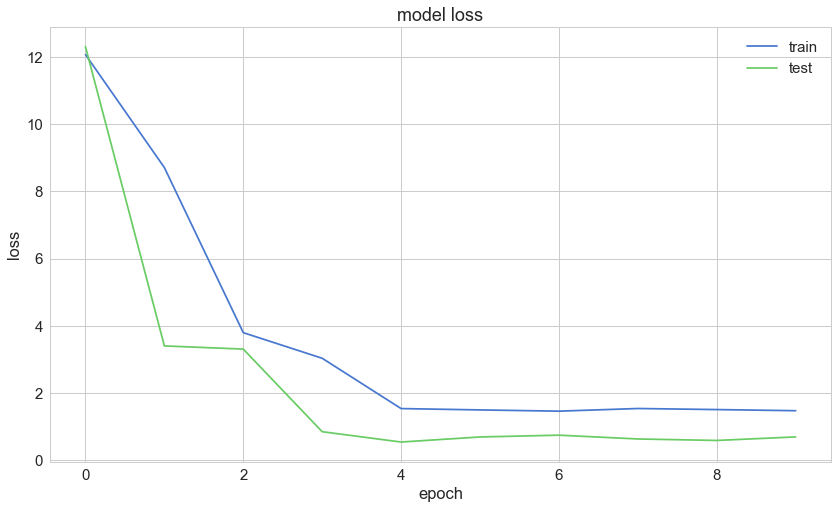

In [129]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

# Автоэнкодер

In [130]:
input_dim = X_train.shape[1]
encoding_dim = X_train.shape[1]//2 # 12

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [138]:
nb_epoch = 10
batch_size = 32
import keras.backend as K

def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=[r2_score])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)


In [139]:
history = autoencoder.fit(X_train, X_train, epochs=nb_epoch, batch_size=batch_size,
                          shuffle=True, validation_data=(X_test, X_test), verbose=1, 
                          callbacks=[checkpointer]).history

Train on 23400 samples, validate on 6600 samples
Epoch 1/10
23400/23400 [==============================] - 3s 120us/step - loss: 12362285.8256 - r2_score: -0.0252 - val_loss: 12596980.7485 - val_r2_score: -0.0252
Epoch 2/10
23400/23400 [==============================] - 2s 68us/step - loss: 12355963.6595 - r2_score: -0.0247 - val_loss: 12590591.3533 - val_r2_score: -0.0247
Epoch 3/10
23400/23400 [==============================] - 2s 68us/step - loss: 12349650.8694 - r2_score: -0.0241 - val_loss: 12584190.1758 - val_r2_score: -0.0242
Epoch 4/10
23400/23400 [==============================] - 1s 53us/step - loss: 12343334.8520 - r2_score: -0.0236 - val_loss: 12577791.2655 - val_r2_score: -0.0236
Epoch 5/10
23400/23400 [==============================] - 1s 61us/step - loss: 12337021.6472 - r2_score: -0.0231 - val_loss: 12571396.5006 - val_r2_score: -0.0231
Epoch 6/10
23400/23400 [==============================] - 1s 62us/step - loss: 12330712.4882 - r2_score: -0.0225 - val_loss: 12565006.3